<a href="https://colab.research.google.com/github/eroj333/learning-cv-ml/blob/master/SNN/Learning%20Similarity%20Function.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# One shot learning and Siamese NN

Commonly, the computer vision today are heavily dependent on Deep Convolution networks. The classification models  require large amount of labelled data and predict a probability over fixed output space. This approach has multiple limitations. Firstly, there is a possibility that a large amount of data cannot be collected. Also, another drawback is that we need to retrain the model everytime the output space changes. This is both cumbersome and expensive.

One Shot Learning helps to ameliorate the limitaiton of the traditional learning method. Using this method, the NN can learn with as less as a single example of each class. This is accomplished by learning a similarity function instead of a classification model. With new classes of data, we can take a single example that can serve as a reference to the similarity function and the model can identify new instances of the class easily.  

In [1]:
import keras as k
import numpy as np 
from keras.layers import *
from keras.models import Sequential, Model
from keras.regularizers import l2
import matplotlib.pyplot as plt
from keras.optimizers import Adam


Using TensorFlow backend.


# Siamese Neural Network (SNN)

SNN is an architecture that employs one shot learning. This type of architecture consists of multiple models that share identical sub components and weights. 

Here we will look at two type of implementation of the SNN in the field of Computer Vision. With the first implementation we will learn a similarity function to predict if two images belong to same class. In the second part we will generate the face embeddings with the triplet loss function.

# Dataset

In [2]:
(x_train_master, y_train_master), (x_test_master, y_test_master) = k.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [0]:
x_train_master = np.expand_dims(x_train_master, axis=3) / 255
x_test_master = np.expand_dims(x_test_master, axis=3) / 255

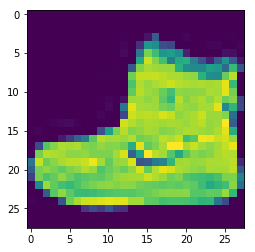

In [4]:
plt.imshow( np.squeeze(x_train_master[0]))

In [0]:
def create_tuples(x, y, n_ways):
  y = y.flatten()
  x_t1 = []
  x_t2 = []
  target = []
  length = len(y)
  
  for i in range(length):
    cur_x, cur_y = x[i], y[i]
    choices = np.random.choice(length, n_ways, replace=False)
    choices_x, choices_y = x[choices], y[choices]
    for j in range(n_ways):
      _x, _y = choices_x[j], choices_y[j]
      x_t1.append(cur_x)
      x_t2.append(_x)
      target.append(1 if cur_y == _y else 0)
    
  return [np.array(x_t1), np.array(x_t2)], np.array(target)

def equalize_class_examples(x, y):
  x1, x2 = x
  y1 = np.where(y == 1) 
  
  n = y1[0].shape[0]
  y0 = np.where(y == 0)[0]
  y0 = y0[:n]
  
  xa = np.vstack((x1[y1], x1[y0]))
  xb = np.vstack((x2[y1], x2[y0]))
  
  yp = np.hstack((y[y1], y[y0]))
  return [xa, xb], yp

def get_training_data(sample_per_class=5, n_ways=5, batch_size = 32, valid_sample_per_class=2, test_sample_per_class=2):
  train_x, train_y, valid_x, valid_y, test_x, test_y = None, None, None, None, None, None
  
  for i in range(10):
    indices = np.argwhere(y_train_master == i)
    choice = np.random.choice(indices.shape[0], sample_per_class + valid_sample_per_class, replace=False)
    choice = indices[choice]

    sub_train_x = x_train_master[choice[:sample_per_class]]
    sub_train_y = y_train_master[choice[:sample_per_class]]
    
    sub_valid_x = x_train_master[choice[sample_per_class:]]
    sub_valid_y = y_train_master[choice[sample_per_class:]]
    
    
    
    t_indices = np.argwhere(y_test_master == i)
    t_choice = np.random.choice(t_indices.shape[0], test_sample_per_class, replace=False)
    t_choice = t_indices[t_choice]
    sub_test_x = x_test_master[t_choice]
    sub_test_y = y_test_master[t_choice]
    
    sub_train_x, sub_train_y, sub_valid_x, sub_valid_y, sub_test_x, sub_test_y = np.squeeze(sub_train_x, axis=1), (sub_train_y), np.squeeze(sub_valid_x, axis=1), (sub_valid_y), np.squeeze(sub_test_x, axis=1), (sub_test_y)
    print(train_x is None)
    if(train_x is None):
      train_x, train_y, valid_x, valid_y, test_x, test_y = sub_train_x, sub_train_y, sub_valid_x, sub_valid_y, sub_test_x, sub_test_y
    else:
      train_x = np.vstack((train_x, sub_train_x))
      train_y = np.vstack((train_y, sub_train_y))
  #     train_x.append(sub_train_x)
  #     train_y.append(sub_train_y)

      valid_x = np.vstack((valid_x, sub_valid_x))
      valid_y = np.vstack((valid_y, sub_valid_y))
  #     valid_x.append(sub_valid_x)
  #     valid_y.append(sub_valid_y)

      test_x = np.vstack((test_x, sub_test_x))
      test_y = np.vstack((test_y, sub_test_y))

  #     test_x.append(sub_test_x)
  #     test_y.append(sub_test_y)
  print(train_x.shape, train_y.shape)
  train_x, train_y = create_tuples(train_x, train_y, n_ways)
  train_x, train_y = equalize_class_examples(train_x, train_y)
  valid_x, valid_y = create_tuples(valid_x, valid_y, n_ways)
  valid_x, valid_y = equalize_class_examples(valid_x, valid_y)
  test_x, test_y = create_tuples(test_x, test_y, n_ways)
  test_x, test_y = equalize_class_examples(test_x, test_y)
  
  return train_x, train_y, valid_x, valid_y, test_x, test_y
  
    

In [0]:
def visualize_data(data, data_class, n):
  n = min(len(data[0]), n)
  print("Same class: ", np.where(data_class ==1)[0].shape[0], "Different class: ", np.where(data_class==0)[0].shape[0])
  fig, ax = plt.subplots(n, 2,figsize=(10,40))
  inp1, inp2 = data
  for i in range(n):
    ax[i, 0].imshow(np.squeeze(inp1[i]), cmap="gray")
    ax[i, 1].imshow(np.squeeze(inp2[i]), cmap="gray")
    # x_class = str(data_class[i].tolist())
    # ax[i, 1].set_title("class " + x_class)

    ax[i, 0].set_axis_off()
    ax[i, 1].set_axis_off()

In [10]:
train_x, train_y, valid_x, valid_y, test_x, test_y = get_training_data(sample_per_class=50, n_ways=10, batch_size = 32, valid_sample_per_class=20, test_sample_per_class=50)

True
False
False
False
False
False
False
False
False
False
(500, 28, 28, 1) (500, 1)


Same class:  472 Different class:  472


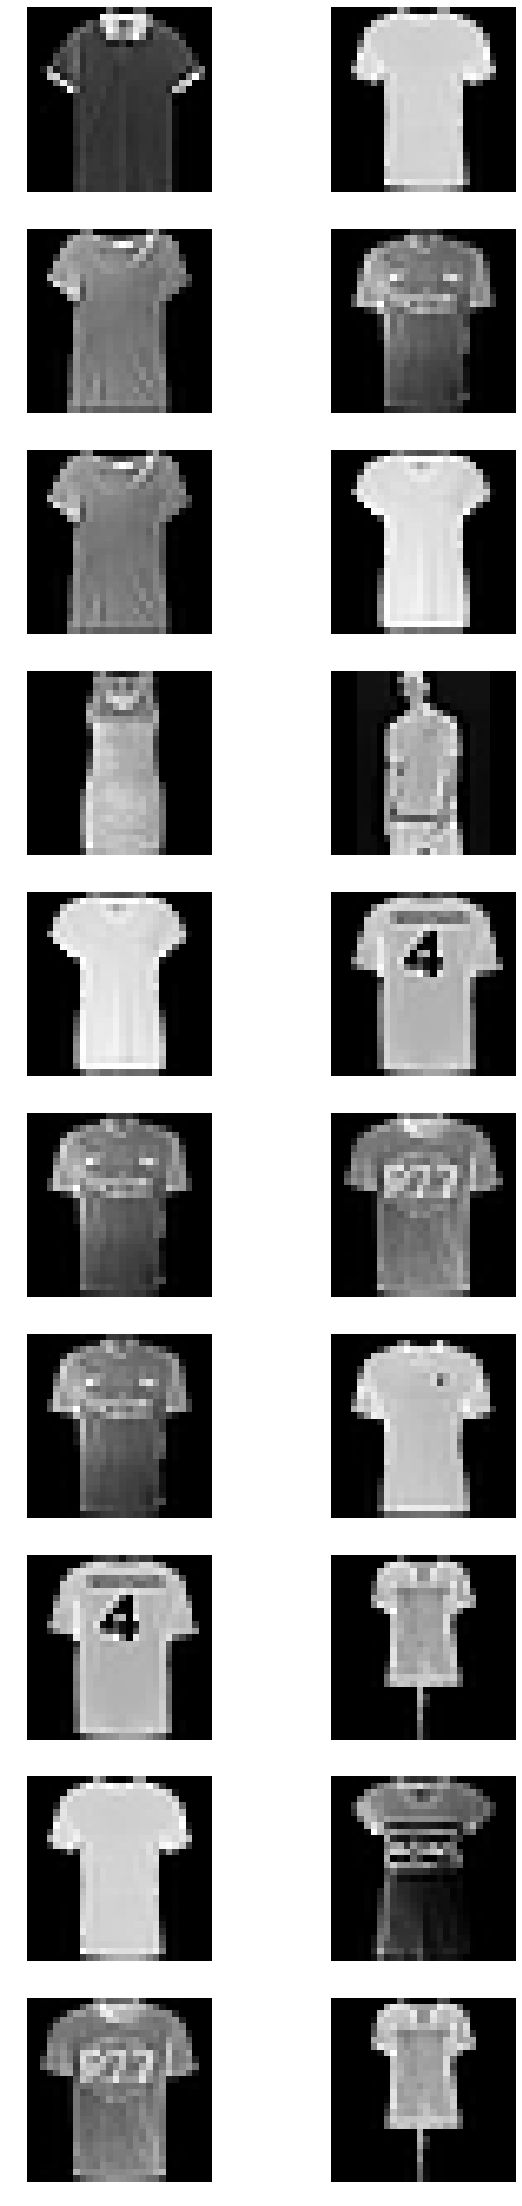

In [17]:
visualize_data(train_x, train_y, 10)


# Learning similarity function



In [0]:
initialize_weights = k.initializers.RandomNormal(mean=0.0, stddev=0.51, seed=50001)
initialize_bias = k.initializers.RandomNormal(mean=0.0, stddev=0.1, seed=1221)


In [0]:
def get_siamese_conv_unit(input_shape):
  # Convolutional Neural Network
    model = Sequential()
    model.add(Conv2D(32, (5,5), activation='relu', input_shape=input_shape,
                   kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(64, (3,3), activation='relu',
                     kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(100, (1,1), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(1024, activation='sigmoid', 
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias))
    model.add(Dropout(rate=.05))
    
    
    return model


def get_classifier_model(input_shape):
    """
        Model architecture
    """
    
    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    # Convolutional Neural Network
    model = get_siamese_conv_unit(input_shape)
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:k.backend.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(L1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    
    # return the model
    return siamese_net


In [0]:
ip_shape = (28,28,1)
model = get_classifier_model(ip_shape)

optimizer = Adam(lr = 0.000001)
model.compile(loss="binary_crossentropy",optimizer=optimizer, metrics=['accuracy'])








Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
model.summary()
# model.get_layer("sequential_1").summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 1024)         2586852     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1024)         0           sequential_1[1][0]         

In [0]:
hist = model.fit(train_x, train_y, epochs=500, validation_data=(valid_x, valid_y))

Train on 986 samples, validate on 378 samples
Epoch 1/5000
986/986 [==============================] - 4s 4ms/step - loss: 669.0556 - acc: 0.5375 - val_loss: 669.0113 - val_acc: 0.5159
Epoch 2/5000
986/986 [==============================] - 0s 279us/step - loss: 668.9941 - acc: 0.5487 - val_loss: 668.9504 - val_acc: 0.5212
Epoch 3/5000
986/986 [==============================] - 0s 278us/step - loss: 668.9235 - acc: 0.5680 - val_loss: 668.8894 - val_acc: 0.5238
Epoch 4/5000
986/986 [==============================] - 0s 288us/step - loss: 668.8685 - acc: 0.5497 - val_loss: 668.8283 - val_acc: 0.5238
Epoch 5/5000
986/986 [==============================] - 0s 278us/step - loss: 668.8014 - acc: 0.5456 - val_loss: 668.7674 - val_acc: 0.5265
Epoch 6/5000
986/986 [==============================] - 0s 275us/step - loss: 668.7516 - acc: 0.5456 - val_loss: 668.7065 - val_acc: 0.5317
Epoch 7/5000
986/986 [==============================] - 0s 274us/step - loss: 668.6929 - acc: 0.5467 - val_loss: 668

In [0]:
model.evaluate(x=test_x, y=test_y)

1016/1016 [==============================] - 0s 94us/step


[410.98900454063113, 0.7667322839338948]

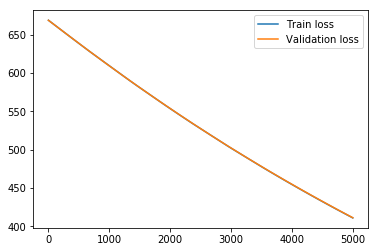

In [0]:
import matplotlib.pyplot as plt
plt.plot(hist.epoch, hist.history["loss"], label="Train loss")
plt.plot(hist.epoch, hist.history["val_loss"], label="Validation loss")
plt.legend(loc='upper right')

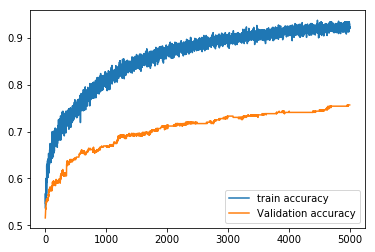

In [0]:
plt.plot(hist.epoch, hist.history["acc"], label="train accuracy")
plt.plot(hist.epoch, hist.history["val_acc"], label="Validation accuracy")
plt.legend(loc='lower right')

Same class:  508 Different class:  508


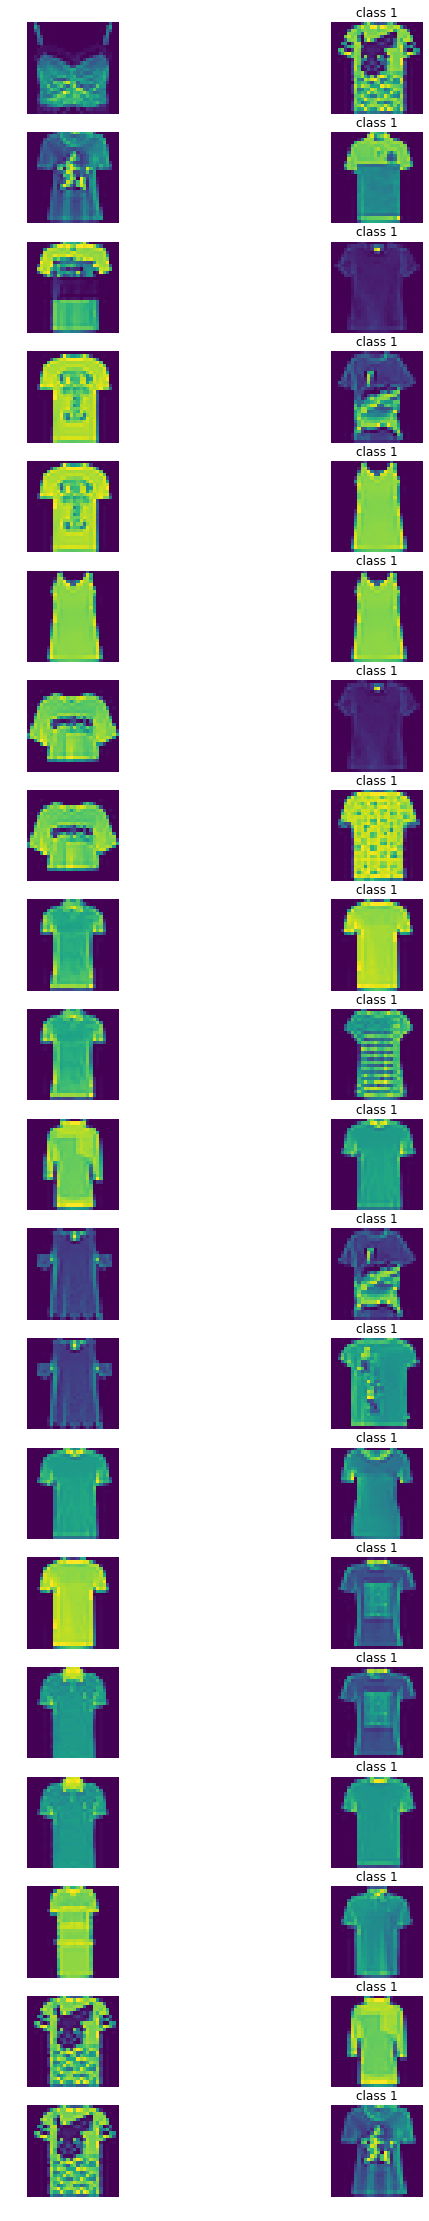

In [0]:
visualize_data(test_x, test_y, 20)

## Tests



### Test 1: All Classes, Single example per class, 10 way training

In [0]:
train_x, train_y, valid_x, valid_y, test_x, test_y = get_training_data(sample_per_class=1, n_ways=10, batch_size = 32, valid_sample_per_class=20, test_sample_per_class=50)


True
False
False
False
False
False
False
False
False
False
(10, 28, 28, 1) (10, 1)


In [0]:
ip_shape = (28,28,1)
model = get_classifier_model(ip_shape)

optimizer = Adam(lr = 0.00000005)
model.compile(loss="binary_crossentropy",optimizer=optimizer, metrics=['accuracy'])

In [0]:
# visualize_data(train_x, train_y, 5)

In [0]:
hist = model.fit(train_x, train_y, epochs=500, validation_data=(valid_x, valid_y))

Train on 20 samples, validate on 372 samples
Epoch 1/500
20/20 [==============================] - 1s 37ms/step - loss: 669.2401 - acc: 0.0500 - val_loss: 669.1600 - val_acc: 0.3952
Epoch 2/500
20/20 [==============================] - 0s 3ms/step - loss: 669.1450 - acc: 0.3000 - val_loss: 669.1600 - val_acc: 0.3952
Epoch 3/500
20/20 [==============================] - 0s 2ms/step - loss: 669.2450 - acc: 0.2000 - val_loss: 669.1599 - val_acc: 0.3952
Epoch 4/500
20/20 [==============================] - 0s 2ms/step - loss: 669.2770 - acc: 0.1500 - val_loss: 669.1596 - val_acc: 0.3952
Epoch 5/500
20/20 [==============================] - 0s 2ms/step - loss: 669.1420 - acc: 0.3500 - val_loss: 669.1595 - val_acc: 0.3952
Epoch 6/500
20/20 [==============================] - 0s 2ms/step - loss: 669.1663 - acc: 0.2500 - val_loss: 669.1595 - val_acc: 0.3952
Epoch 7/500
20/20 [==============================] - 0s 2ms/step - loss: 669.1736 - acc: 0.2500 - val_loss: 669.1594 - val_acc: 0.3952
Epoch 8/5

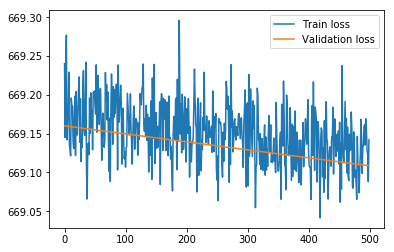

In [0]:
plt.plot(hist.epoch, hist.history["loss"], label="Train loss")
plt.plot(hist.epoch, hist.history["val_loss"], label="Validation loss")
plt.legend(loc='upper right')

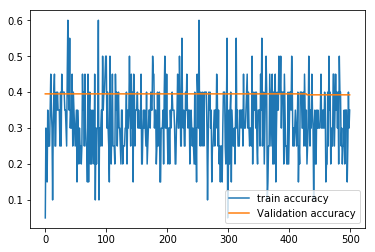

In [0]:
plt.plot(hist.epoch, hist.history["acc"], label="train accuracy")
plt.plot(hist.epoch, hist.history["val_acc"], label="Validation accuracy")
plt.legend(loc='lower right')

In [0]:
model.evaluate(x=test_x, y=test_y)

1016/1016 [==============================] - 0s 99us/step


[669.1108951118049, 0.4153543308259934]

### Test 2: All Classes, Single example per class, 5 way training

In [0]:
train_x, train_y, valid_x, valid_y, test_x, test_y = get_training_data(sample_per_class=1, n_ways=5, batch_size = 32, valid_sample_per_class=20, test_sample_per_class=50)


True
False
False
False
False
False
False
False
False
False
(10, 28, 28, 1) (10, 1)


In [0]:
train_y.shape

(10,)

In [0]:
ip_shape = (28,28,1)
model = get_classifier_model(ip_shape)

optimizer = Adam(lr = 1e-9)
model.compile(loss="binary_crossentropy",optimizer=optimizer, metrics=['accuracy'])

In [0]:
hist = model.fit(train_x, train_y, epochs=1000, validation_data=(valid_x, valid_y))

Train on 10 samples, validate on 190 samples
Epoch 1/1000
10/10 [==============================] - 1s 82ms/step - loss: 669.0804 - acc: 0.7000 - val_loss: 669.0942 - val_acc: 0.4632
Epoch 2/1000
10/10 [==============================] - 0s 3ms/step - loss: 669.2031 - acc: 0.4000 - val_loss: 669.0942 - val_acc: 0.4632
Epoch 3/1000
10/10 [==============================] - 0s 3ms/step - loss: 669.2781 - acc: 0.3000 - val_loss: 669.0942 - val_acc: 0.4632
Epoch 4/1000
10/10 [==============================] - 0s 3ms/step - loss: 669.1482 - acc: 0.3000 - val_loss: 669.0942 - val_acc: 0.4632
Epoch 5/1000
10/10 [==============================] - 0s 3ms/step - loss: 669.0839 - acc: 0.7000 - val_loss: 669.0942 - val_acc: 0.4632
Epoch 6/1000
10/10 [==============================] - 0s 3ms/step - loss: 669.2301 - acc: 0.5000 - val_loss: 669.0942 - val_acc: 0.4632
Epoch 7/1000
10/10 [==============================] - 0s 3ms/step - loss: 669.0874 - acc: 0.6000 - val_loss: 669.0942 - val_acc: 0.4632
Ep

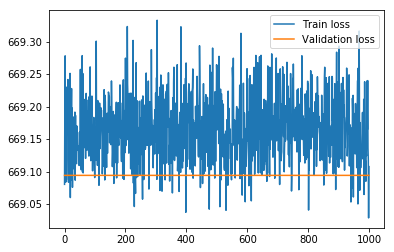

In [0]:
plt.plot(hist.epoch, hist.history["loss"], label="Train loss")
plt.plot(hist.epoch, hist.history["val_loss"], label="Validation loss")
plt.legend(loc='upper right')

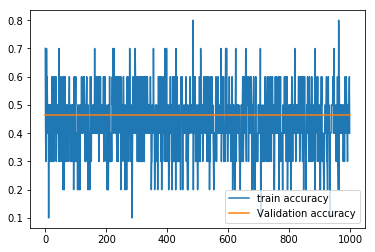

In [0]:
plt.plot(hist.epoch, hist.history["acc"], label="train accuracy")
plt.plot(hist.epoch, hist.history["val_acc"], label="Validation accuracy")
plt.legend(loc='lower right')

In [0]:
model.evaluate(x=test_x, y=test_y)

492/492 [==============================] - 0s 105us/step


[669.0975917412983, 0.5182926830479769]

### Test 3: First 5 classes for training, another 5 for testing, 1 example, 5 way training

In [0]:


def get_training_data(sample_per_class=5, n_ways=5, batch_size = 32, valid_sample_per_class=2, test_sample_per_class=2):
  train_x, train_y, valid_x, valid_y, test_x, test_y = None, None, None, None, None, None
  
  for i in range(5):
    indices = np.argwhere(y_train_master == i)
    choice = np.random.choice(indices.shape[0], sample_per_class + valid_sample_per_class, replace=False)
    choice = indices[choice]

    sub_train_x = x_train_master[choice[:sample_per_class]]
    sub_train_y = y_train_master[choice[:sample_per_class]]
    
    sub_valid_x = x_train_master[choice[sample_per_class:]]
    sub_valid_y = y_train_master[choice[sample_per_class:]]
    
    sub_train_x, sub_train_y, sub_valid_x, sub_valid_y = np.squeeze(sub_train_x, axis=1), (sub_train_y), np.squeeze(sub_valid_x, axis=1), (sub_valid_y)
    
    if(train_x is None):
      train_x, train_y, valid_x, valid_y = sub_train_x, sub_train_y, sub_valid_x, sub_valid_y
    else:
      train_x = np.vstack((train_x, sub_train_x))
      train_y = np.vstack((train_y, sub_train_y))

      valid_x = np.vstack((valid_x, sub_valid_x))
      valid_y = np.vstack((valid_y, sub_valid_y))
    
  for i in range(5,10):
    t_indices = np.argwhere(y_test_master == i)
    t_choice = np.random.choice(t_indices.shape[0], test_sample_per_class, replace=False)
    t_choice = t_indices[t_choice]
    sub_test_x = x_test_master[t_choice]
    sub_test_y = y_test_master[t_choice]
    
    sub_test_x, sub_test_y =  np.squeeze(sub_test_x, axis=1), (sub_test_y)

    if(test_x is None):
      test_x, test_y = sub_test_x, sub_test_y
    else:
      test_x = np.vstack((test_x, sub_test_x))
      test_y = np.vstack((test_y, sub_test_y))

      
  train_x, train_y = create_tuples(train_x, train_y, n_ways)
  train_x, train_y = equalize_class_examples(train_x, train_y)
  
  valid_x, valid_y = create_tuples(valid_x, valid_y, n_ways)
  valid_x, valid_y = equalize_class_examples(valid_x, valid_y)
  test_x, test_y = create_tuples(test_x, test_y, n_ways)
  test_x, test_y = equalize_class_examples(test_x, test_y)
  
  return train_x, train_y, valid_x, valid_y, test_x, test_y

In [0]:
train_x, train_y, valid_x, valid_y, test_x, test_y = get_training_data(sample_per_class=1, n_ways=2, batch_size = 32, valid_sample_per_class=20, test_sample_per_class=50)
print(train_y.shape)

(6,)


In [0]:
# visualize_data(train_x, train_y, 20)

In [0]:
# visualize_data(test_x, test_y, 20)

In [0]:
ip_shape = (28,28,1)
model = get_classifier_model(ip_shape)

optimizer = Adam(lr = 1e-14)
model.compile(loss="binary_crossentropy",optimizer=optimizer, metrics=['accuracy'])

In [0]:
hist = model.fit(train_x, train_y, epochs=500, validation_data=(valid_x, valid_y), shuffle=True)

Train on 6 samples, validate on 82 samples
Epoch 1/500
6/6 [==============================] - 1s 197ms/step - loss: 668.9790 - acc: 0.6667 - val_loss: 669.0788 - val_acc: 0.5244
Epoch 2/500
6/6 [==============================] - 0s 3ms/step - loss: 668.8344 - acc: 0.8333 - val_loss: 669.0788 - val_acc: 0.5244
Epoch 3/500
6/6 [==============================] - 0s 3ms/step - loss: 669.0840 - acc: 0.5000 - val_loss: 669.0788 - val_acc: 0.5244
Epoch 4/500
6/6 [==============================] - 0s 3ms/step - loss: 668.9556 - acc: 0.5000 - val_loss: 669.0788 - val_acc: 0.5244
Epoch 5/500
6/6 [==============================] - 0s 3ms/step - loss: 668.9476 - acc: 0.6667 - val_loss: 669.0788 - val_acc: 0.5244
Epoch 6/500
6/6 [==============================] - 0s 3ms/step - loss: 668.9666 - acc: 0.6667 - val_loss: 669.0788 - val_acc: 0.5244
Epoch 7/500
6/6 [==============================] - 0s 3ms/step - loss: 668.9948 - acc: 0.5000 - val_loss: 669.0788 - val_acc: 0.5244
Epoch 8/500
6/6 [=======

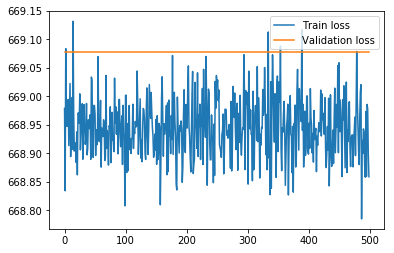

In [0]:
plt.plot(hist.epoch, hist.history["loss"], label="Train loss")
plt.plot(hist.epoch, hist.history["val_loss"], label="Validation loss")
plt.legend(loc='upper right')

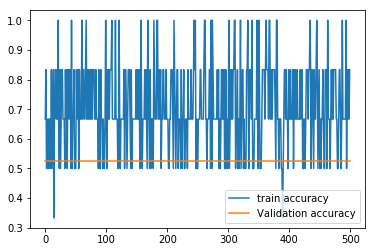

In [0]:
plt.plot(hist.epoch, hist.history["acc"], label="train accuracy")
plt.plot(hist.epoch, hist.history["val_acc"], label="Validation accuracy")
plt.legend(loc='lower right')

In [0]:
model.evaluate(x=test_x, y=test_y)

210/210 [==============================] - 0s 156us/step


[669.0746058872768, 0.5380952363922482]

### Test 4: First 5 classes for training, another 5 for testing, 50 examples for each class, 5 way training

In [0]:
train_x, train_y, valid_x, valid_y, test_x, test_y = get_training_data(sample_per_class=50, n_ways=5, batch_size = 32, valid_sample_per_class=50, test_sample_per_class=50)


In [0]:
# visualize_data(train_x, train_y, 5)

In [0]:
# visualize_data(test_x, test_y, 5)

In [0]:
ip_shape = (28,28,1)
model = get_classifier_model(ip_shape)

optimizer = Adam(lr = 1E-6)
model.compile(loss="binary_crossentropy",optimizer=optimizer, metrics=['accuracy'])

In [0]:
hist = model.fit(train_x, train_y, epochs=3000, validation_data=(valid_x, valid_y))

Train on 488 samples, validate on 478 samples
Epoch 1/3000
488/488 [==============================] - 1s 3ms/step - loss: 669.0606 - acc: 0.5574 - val_loss: 669.0118 - val_acc: 0.6004
Epoch 2/3000
488/488 [==============================] - 0s 395us/step - loss: 669.0317 - acc: 0.5389 - val_loss: 668.9802 - val_acc: 0.6046
Epoch 3/3000
488/488 [==============================] - 0s 360us/step - loss: 669.0011 - acc: 0.5471 - val_loss: 668.9486 - val_acc: 0.6025
Epoch 4/3000
488/488 [==============================] - 0s 347us/step - loss: 668.9520 - acc: 0.5697 - val_loss: 668.9169 - val_acc: 0.6046
Epoch 5/3000
488/488 [==============================] - 0s 343us/step - loss: 668.9277 - acc: 0.5533 - val_loss: 668.8853 - val_acc: 0.6046
Epoch 6/3000
488/488 [==============================] - 0s 343us/step - loss: 668.8869 - acc: 0.5574 - val_loss: 668.8536 - val_acc: 0.6046
Epoch 7/3000
488/488 [==============================] - 0s 346us/step - loss: 668.8528 - acc: 0.6025 - val_loss: 668

In [0]:
model.evaluate(x=test_x, y=test_y)

530/530 [==============================] - 0s 89us/step


[577.7016981592718, 0.5433962267524791]

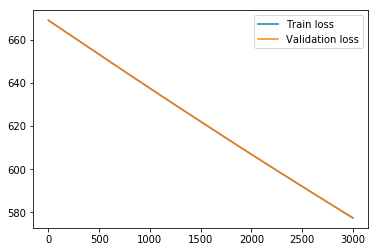

In [0]:
plt.plot(hist.epoch, hist.history["loss"], label="Train loss")
plt.plot(hist.epoch, hist.history["val_loss"], label="Validation loss")
plt.legend(loc='upper right')

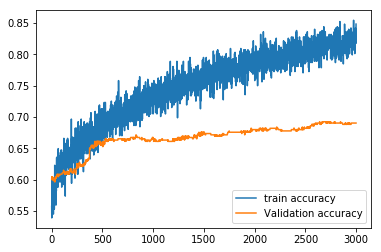

In [0]:
plt.plot(hist.epoch, hist.history["acc"], label="train accuracy")
plt.plot(hist.epoch, hist.history["val_acc"], label="Validation accuracy")
plt.legend(loc='lower right')

# Observation
The best model trained in this notebook is the first model which has an accuracy of ~72%. This model was trained with 50 examples of each class. 